# Data Loading and Preparation

## Import libraries and load data

In [86]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# LangChain Modules
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_openai import ChatOpenAI
# from langchain.llms import OpenAI
# from langchain.chat_models import ChatOpenAI

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)

In [87]:
df = pd.read_csv('data/twcs/twcs.csv')
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


## Correct the format of the columns

In [88]:
df['tweet_id'] = df['tweet_id'].astype(str)
df['in_response_to_tweet_id'] = df['in_response_to_tweet_id'].astype(str)
df['response_tweet_id'] = df['response_tweet_id'].astype(str)
df['author_id'] = df['author_id'].astype(str)
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
df['created_at'] = df['created_at'].dt.tz_localize(None)

# replace non standard missing values with np.nan
df.replace(['', 'nan', None], np.nan, inplace=True)

# Treating the in_response_to_tweet_id column
df['in_response_to_tweet_id'] = df['in_response_to_tweet_id'].apply(lambda x: str(int(float(x))) if pd.notnull(x) else np.nan)

## Tweet conversations and subthreads detection

In [89]:
# Step 1: Pre-process the DataFrame to create helpful mappings
response_mapping = df.set_index('tweet_id')['response_tweet_id'].dropna().to_dict()

# set index 'tweet_id'
df = df.set_index('tweet_id', drop=False)

# Initializing new columns
df['conversation_id'] = pd.Series(np.nan, dtype='object')
df['subthread_id'] = pd.Series(np.nan, dtype='object')
df['parent_id'] = pd.Series(np.nan, dtype='object')
df['depth'] = pd.Series(np.nan, dtype='float')  

# Initialize a dictionary to hold conversation information temporarily
conversation_info = {}

def assign_conversation_info(tweet_id, conversation_id, subthread_path, parent_id=np.nan, current_depth=0):
    if tweet_id in conversation_info:  # Skip if already processed
        return
    
    # Generate a subthread ID based on the current subthread path
    subthread_id = ','.join(map(str, subthread_path)) if subthread_path else np.nan
    
    conversation_info[tweet_id] = {
        'conversation_id': str(conversation_id),
        'subthread_id': subthread_id,
        'parent_id': parent_id,
        'depth': current_depth
    }
    
    # Process responses
    responses = response_mapping.get(tweet_id, "")
    if responses:
        for idx, response_id in enumerate(responses.split(',')):
            new_path = subthread_path + [idx + 1] if subthread_path else []
            assign_conversation_info(response_id.strip(), conversation_id, new_path, tweet_id, current_depth + 1)

# Assign unique conversation IDs
# Starting tweets
start_tweets = df[(df['in_response_to_tweet_id'].isnull()) & (df['inbound'] == True)]
print(f"The number of conversations in the dataset is: {start_tweets.shape[0]}")

conversation_counter = 1  # Initialize conversation counter
for i, row in start_tweets.iterrows():
    if conversation_counter > 100:  # Break the loop after processing 100 conversations
        break
    assign_conversation_info(row['tweet_id'], conversation_counter, [conversation_counter])
    conversation_counter += 1


# Step 2: Batch update the DataFrame using the conversation_info dictionary
for tweet_id, info in conversation_info.items():
    idx = df.index[df['tweet_id'] == tweet_id]
    df.loc[idx, 'conversation_id'] = info['conversation_id']
    df.loc[idx, 'subthread_id'] = info['subthread_id']
    df.loc[idx, 'parent_id'] = info['parent_id']
    df.loc[idx, 'depth'] = info['depth']

# Sort by conversation_id and time for better readability
df.sort_values(by=['conversation_id', 'created_at'], inplace=True)

# drop rows that don't have 'conversation_id'
df = df.dropna(subset=['conversation_id'])


The number of conversations in the dataset is: 787346


In [90]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,subthread_id,parent_id,depth
tweet_id,,,,,,,,,,,
8,8,115712,True,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN,1,1,NaN,0.0
10,10,sprintcare,False,2017-10-31 21:45:59,@115712 Hello! We never like our customers to feel like they are not valued.,NaN,8,1,"1,3",8,1.0
9,9,sprintcare,False,2017-10-31 21:46:14,@115712 I would love the chance to review the account and provide assistance.,NaN,8,1,"1,1",8,1.0
6,6,sprintcare,False,2017-10-31 21:46:24,"@115712 Can you please send us a private message, so that I can gain further details about your account?","5,7",8,1,"1,2",8,1.0
7,7,115712,True,2017-10-31 21:47:48,@sprintcare the only way I can get a response is to tweet apparently,NaN,6,1,"1,2,2",6,2.0


## Column preparation for causal inference analysis

### New column calculations for 'response_time' and 'subthread_creation'

In [91]:
# For simplicity, response is calculated only for the first company response
df['response_time'] = np.nan  # Initialize the column
initial_tweets = df[df['depth'] == 0]

for index, row in initial_tweets.iterrows():
    response_row = df[(df['in_response_to_tweet_id'] == row['tweet_id']) & (df['author_id'] != row['author_id'])].sort_values(by='created_at').head(1)
    if not response_row.empty:
        response_time = (response_row.iloc[0]['created_at'] - row['created_at']).total_seconds() / 60  # Response time in minutes
        df.at[index, 'response_time'] = response_time


In [92]:
# Filter to get starting tweets
starting_tweets_df = df[df['depth'] == 0].copy()

# Calculate 'subthread_creation' for each starting tweet in the new DataFrame
def check_subthread_creation(conversation_id):
    # Check if there are any tweets with a depth > 0 for the same conversation_id
    if df[(df['conversation_id'] == conversation_id) & (df['depth'] > 1)].empty:
        return 0  # No subthreads created
    else:
        return 1  # Subthreads created

# Apply the function to calculate 'subthread_creation'
starting_tweets_df['subthread_creation'] = starting_tweets_df['conversation_id'].apply(check_subthread_creation)


### Calculating length of initial complaint 

In [93]:

# Calculating lenght of the initial complaint
starting_tweets_df['len_complaint'] = starting_tweets_df['text'].apply(len)
starting_tweets_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,subthread_id,parent_id,depth,response_time,subthread_creation,len_complaint
tweet_id,,,,,,,,,,,,,,
8,8,115712,True,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN,1,1,NaN,0.0,0.816667,1,41
59,59,115723,True,2017-10-31 19:54:51,@115722 is the worst ISP I’ve ever had,58,NaN,10,10,NaN,0.0,2.650000,1,38
723,723,115859,True,2017-10-31 22:11:16,@115858 @AppleSupport hello are all the lines closed for tonight #help,722,NaN,100,100,NaN,0.0,6.233333,1,70
61,61,115724,True,2017-10-31 22:00:36,.@VerizonSupport @115725 @115726 &gt;All of VERIZON IS DOWN&lt;\nWhen can we expect a fix ?,60,NaN,11,11,NaN,0.0,3.883333,0,138
63,63,115727,True,2017-10-31 21:56:55,@115725 fix your app it won't even open,62,NaN,12,12,NaN,0.0,3.566667,0,39


In [94]:
def include_day_component(times):
    """Check if day component varies across timestamps."""
    dates = [time.date() for time in times]
    return len(set(dates)) > 1

def get_time_format(times):
    """Determine appropriate time format based on uniformity of day component."""
    include_day = include_day_component(times)
    # Conditionally include the day based on whether it's uniform across all timestamps
    if include_day:
        return "%Y-%m-%d %H:%M:%S"
    else:
        return "%H:%M:%S"


def prepare_conversation_text(start_tweet_id, df):
    # Helper function to recursively build the conversation structure
    times = df[df['conversation_id'] == df.loc[start_tweet_id]['conversation_id']]['created_at'].tolist()
    time_format = get_time_format(times)

    def format_time(created_at):
        """Format 'created_at' timestamp according to determined format."""
        return created_at.strftime(time_format)

    def build_conversation_structure(tweet_id, depth=0):
        # Find the tweet in the DataFrame
        tweet_row = df.loc[df['tweet_id'] == tweet_id]
        if tweet_row.empty:
            return None
        
        tweet_time = format_time(tweet_row.iloc[0]['created_at'])
        # Structure for the current tweet
        tweet_structure = {
            "author_id": tweet_row.iloc[0]['author_id'],
            "text": tweet_row.iloc[0]['text'],
            "time": tweet_time,
            "replies": []
        }

        # Find direct replies to this tweet
        replies = df[df['parent_id'] == tweet_id].sort_values(by=['created_at'])
        for _, reply_row in replies.iterrows():
            # Recursively build the structure for each reply
            reply_structure = build_conversation_structure(reply_row['tweet_id'], depth + 1)
            if reply_structure:
                tweet_structure["replies"].append(reply_structure)
        
        return tweet_structure
    
    # Start building from the first tweet in the conversation
    conversation_structure = build_conversation_structure(start_tweet_id)
    
    return json.dumps(conversation_structure)

# Example usage
start_tweet_id = '8'  # Example conversation ID
conversation_structure = prepare_conversation_text(start_tweet_id, df)



In [95]:
tweet_conversation = """{'author_id': '115712',
 'text': '@sprintcare is the worst customer service',
 'time': '21:45:10',
 'replies': [{'author_id': 'sprintcare',
   'text': '@115712 Hello! We never like our customers to feel like they are not valued.',
   'time': '21:45:59',
   'replies': []},
  {'author_id': 'sprintcare',
   'text': '@115712 I would love the chance to review the account and provide assistance.',
   'time': '21:46:14',
   'replies': []},
  {'author_id': 'sprintcare',
   'text': '@115712 Can you please send us a private message, so that I can gain further details about your account?',
   'time': '21:46:24',
   'replies': [{'author_id': '115712',
     'text': '@sprintcare the only way I can get a response is to tweet apparently',
     'time': '21:47:48',
     'replies': []},
    {'author_id': '115712',
     'text': '@sprintcare I did.',
     'time': '21:49:35',
     'replies': [{'author_id': 'sprintcare',
       'text': '@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.',
       'time': '21:54:49',
       'replies': [{'author_id': '115712',
         'text': '@sprintcare I have sent several private messages and no one is responding as usual',
         'time': '22:08:27',
         'replies': [{'author_id': 'sprintcare',
           'text': '@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.',
           'time': '22:10:47',
           'replies': [{'author_id': '115712',
             'text': '@sprintcare and how do you propose we do that',
             'time': '22:11:45',
             'replies': []}]}]}]}]}]}]}
"""

In [131]:

# llm = OpenAI()
chat_model = ChatOpenAI(model='gpt-4-turbo-preview')

response_schemas = [
    ResponseSchema(name="initial_sentiment", description="What is the initial sentiment of the customer in the first tweet of conversation? (positive, negative, neutral)"),
    ResponseSchema(name="end_sentiment", description="What is the sentiment of the customer towards the end of the conversation? If there is no end tweet by customer and support has provided additional support information then assume neutral or if no support information then assume same as initial sentiment. (positive, negative, neutral)"),
    ResponseSchema(name="personalized", description="Was the response by company personalized for the customer? (yes, no)"),
    ResponseSchema(name="severity", description="What is the severity of the issue discussed? (low, medium, high)")
]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"initial_sentiment": string  // What is the initial sentiment of the customer in the first tweet of conversation? (positive, negative, neutral)
	"end_sentiment": string  // What is the sentiment of the customer towards the end of the conversation? If there is no end tweet by customer and support has provided additional support information then assume neutral or if no support information then assume same as initial sentiment. (positive, negative, neutral)
	"personalized": string  // Was the response by company personalized for the customer? (yes, no)
	"severity": string  // What is the severity of the issue discussed? (low, medium, high)
}
```


In [132]:
prompt_template = PromptTemplate(
    template="""Based on the following tweet conversation between a cusomter and a company support, answer the questions according to the specified categories:
    
    "{tweet_conversation}"

    Questions:
    1. What is the initial sentiment of the customer in the first tweet of conversation? (positive, negative, neutral)
    2. What is the sentiment of the customer towards the end of the conversation? If there is no end tweet by customer and support has provided additional support information then assume neutral or if no support information then assume same as initial sentiment. (positive, negative, neutral)
    3. Was the response by company personalized for the customer? (yes, no)
    4. What is the severity of the issue discussed? (low, medium, high)

    Please format your answers according to the following instructions:
    {format_instructions}
    """,
    input_variables=["tweet_conversation"],
    partial_variables={"format_instructions": format_instructions}
)

# _input = prompt.format_prompt(tweet_conversation=tweet_conversation)
# output = chat_model(_input.to_messages())

def analyze_tweet_conversation(tweet_conversation):
    """
    Analyzes a tweet conversation using LangChain and returns structured output.

    Args:
    - tweet_conversation (str): The tweet conversation text to analyze.

    Returns:
    - dict: Parsed output containing initial sentiment, end sentiment, personalization, and issue severity.
    """
    _input = prompt_template.format_prompt(tweet_conversation=tweet_conversation)
    output = chat_model.invoke(_input.to_messages())
    parsed_output = output_parser.parse(output.content)
    return parsed_output

In [112]:
analyze_tweet_conversation(tweet_conversation)

{'initial_sentiment': 'positive',
 'end_sentiment': 'neutral',
 'personalized': 'yes',
 'severity': 'low'}

In [137]:
# Create new columns in the starting_tweets_df for the initial sentiment, end sentiment, personalized and issue severity with None
starting_tweets_df['initial_sentiment'] = None
starting_tweets_df['end_sentiment'] = None
starting_tweets_df['personalized'] = None
starting_tweets_df['severity'] = None

for tweet_id in starting_tweets_df['tweet_id']:
    # Prepare the conversation text
    conversation_text = prepare_conversation_text(tweet_id, df)
    
    # Analyze the conversation text with the LLM through LangChain
    analysis_result = analyze_tweet_conversation(conversation_text)

    # Update the starting_tweets_df with the analysis results
    starting_tweets_df.update(pd.DataFrame(analysis_result, index=[tweet_id]))


In [155]:
# Define a mapping from sentiment labels to numerical values
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
severity_mapping = {'low': 0, 'medium': 1, 'high': 2}
personalized_mapping = {'no': 0, 'yes': 1}

# Map the sentiment labels to numerical values
starting_tweets_df['initial_sentiment_value'] = starting_tweets_df['initial_sentiment'].map(sentiment_mapping)
starting_tweets_df['end_sentiment_value'] = starting_tweets_df['end_sentiment'].map(sentiment_mapping)
starting_tweets_df['severity_value'] = starting_tweets_df['severity'].map(severity_mapping)
starting_tweets_df['personalized_value'] = starting_tweets_df['personalized'].map(personalized_mapping)

# Calculate the change in sentiment as the difference between end and initial sentiment values
starting_tweets_df['change_in_sentiment'] = starting_tweets_df['end_sentiment_value'] - starting_tweets_df['initial_sentiment_value']
starting_tweets_df['sentiment_improved'] = starting_tweets_df['change_in_sentiment'].apply(lambda x: 1 if x > 0 else 0)


In [156]:
starting_tweets_df.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,subthread_id,parent_id,depth,response_time,subthread_creation,len_complaint,initial_sentiment,end_sentiment,personalized,severity,initial_sentiment_value,end_sentiment_value,change_in_sentiment,severity_value,personalized_value,sentiment_improved
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,
8,8,115712,True,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN,1,1,NaN,0.0,0.816667,1,41,negative,negative,yes,high,-1,-1,0,2,1,0
59,59,115723,True,2017-10-31 19:54:51,@115722 is the worst ISP I’ve ever had,58,NaN,10,10,NaN,0.0,2.650000,1,38,negative,negative,yes,high,-1,-1,0,2,1,0
723,723,115859,True,2017-10-31 22:11:16,@115858 @AppleSupport hello are all the lines closed for tonight #help,722,NaN,100,100,NaN,0.0,6.233333,1,70,neutral,neutral,yes,low,0,0,0,0,1,0
61,61,115724,True,2017-10-31 22:00:36,.@VerizonSupport @115725 @115726 &gt;All of VERIZON IS DOWN&lt;\nWhen can we expect a fix ?,60,NaN,11,11,NaN,0.0,3.883333,0,138,negative,neutral,yes,high,-1,0,1,2,1,1
63,63,115727,True,2017-10-31 21:56:55,@115725 fix your app it won't even open,62,NaN,12,12,NaN,0.0,3.566667,0,39,negative,negative,yes,high,-1,-1,0,2,1,0


In [157]:
df.to_excel("data/df.xlsx", index=False)
starting_tweets_df.to_excel("data/starting_tweets_df.xlsx", index=False)

# Exploratory Data Analysis (EDA):

### Descriptive Statistics
A quick look at the central tendencies and dispersion:

In [160]:
# Descriptive statistics for numerical columns
starting_tweets_df[['response_time', 'len_complaint', 'initial_sentiment_value',
                          'end_sentiment_value', 'severity_value', 'personalized_value',
                          'sentiment_improved']].describe()

,response_time,len_complaint,initial_sentiment_value,end_sentiment_value,severity_value,personalized_value,sentiment_improved
count,9.600000e+01,100.000000,100.00000,100.000000,100.000000,100.00,100.000000
mean,3.425204e+04,105.670000,-0.51000,-0.010000,0.930000,0.99,0.540000
std,3.304667e+05,36.825018,0.71767,0.577263,0.843933,0.10,0.500908
min,8.166667e-01,24.000000,-1.00000,-1.000000,0.000000,0.00,0.000000
25%,6.570833e+00,80.000000,-1.00000,0.000000,0.000000,1.00,0.000000
50%,1.340833e+01,108.000000,-1.00000,0.000000,1.000000,1.00,1.000000
75%,1.412500e+02,135.250000,0.00000,0.000000,2.000000,1.00,1.000000
max,3.238378e+06,167.000000,1.00000,1.000000,2.000000,1.00,1.000000


### Visualization

#### Response Time Distribution

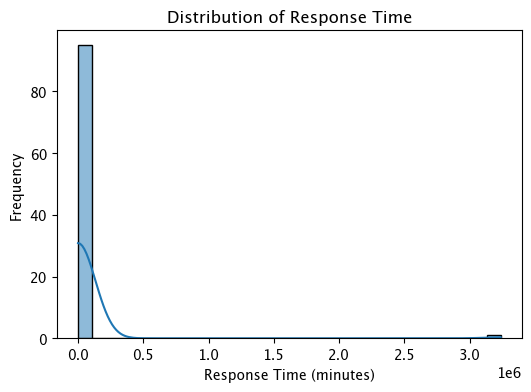

In [162]:
plt.figure(figsize=(6, 4))
sns.histplot(starting_tweets_df['response_time'], bins=30, kde=True)
plt.title('Distribution of Response Time')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Frequency')
plt.show()

#### Sentiment Values Distribution

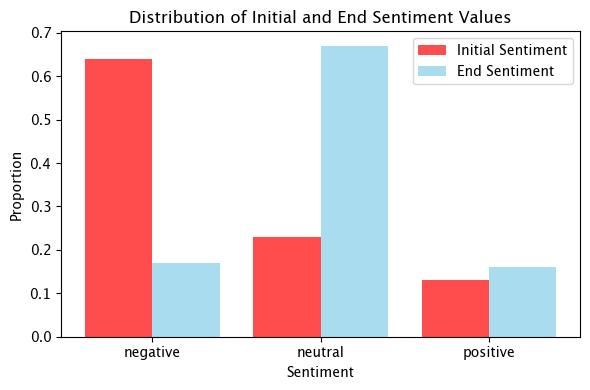

In [198]:
# Prepare data for plotting
sentiment_counts_initial = starting_tweets_df['initial_sentiment'].value_counts(normalize=True)
sentiment_counts_end = starting_tweets_df['end_sentiment'].value_counts(normalize=True)

# consistent ordering of sentiment categories across both series
sentiment_order = ["negative", "neutral", "positive"]
sentiment_counts_initial = sentiment_counts_initial.reindex(sentiment_order).reset_index()
sentiment_counts_end = sentiment_counts_end.reindex(sentiment_order).reset_index()

# Plotting
plt.figure(figsize=(6, 4))
# Setting the positions and width for the bars
pos = list(range(len(sentiment_counts_initial['initial_sentiment'])))
width = 0.4  # the width of a bar

# Plotting the bars
plt.bar(pos, sentiment_counts_initial['proportion'], width, alpha=0.7, color='red', label='Initial Sentiment')
plt.bar([p + width for p in pos], sentiment_counts_end['proportion'], width, alpha=0.7, color='skyblue', label='End Sentiment')

plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.title('Distribution of Initial and End Sentiment Values')
plt.xticks([p + width/2 for p in pos], sentiment_order)

plt.legend(['Initial Sentiment', 'End Sentiment'], loc='upper right')
plt.tight_layout()
plt.show()

#### Proportion of Personalized Responses

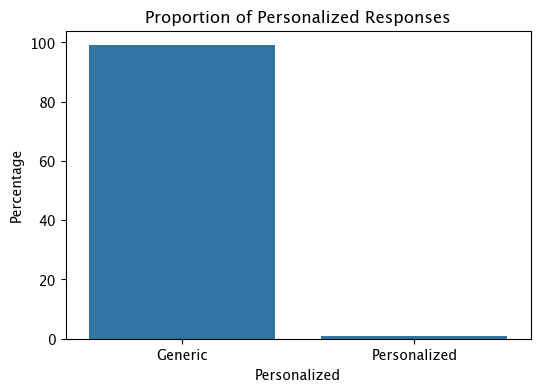

In [167]:
personalized_counts = starting_tweets_df['personalized'].value_counts(normalize=True) * 100
plt.figure(figsize=(6, 4))
sns.barplot(x=personalized_counts.index, y=personalized_counts.values)
plt.title('Proportion of Personalized Responses')
plt.xlabel('Personalized')
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['Generic', 'Personalized'])
plt.show()

#### Subthread Creation

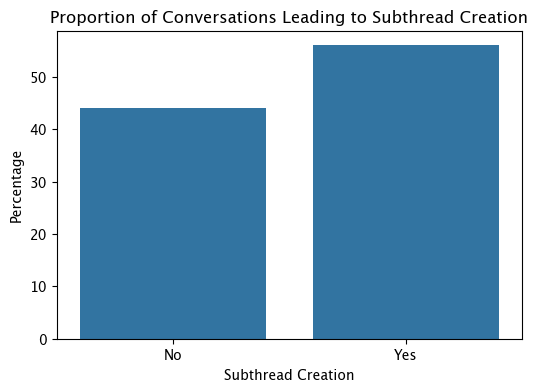

In [168]:
subthread_counts = starting_tweets_df['subthread_creation'].value_counts(normalize=True) * 100
plt.figure(figsize=(6, 4))
sns.barplot(x=subthread_counts.index, y=subthread_counts.values)
plt.title('Proportion of Conversations Leading to Subthread Creation')
plt.xlabel('Subthread Creation')
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

#### Box Plot for Severity vs. Response Time
To see if the severity of the issue affects the response time:

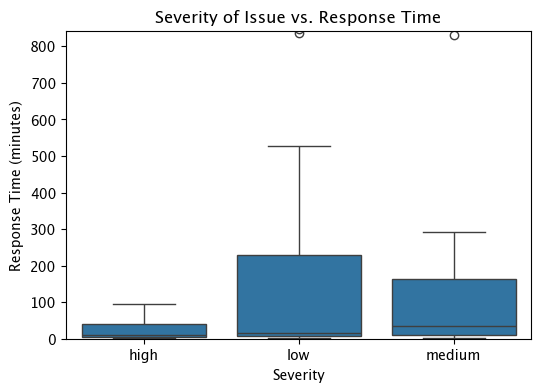

In [204]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='severity', y='response_time', data=starting_tweets_df)
plt.ylim(0, starting_tweets_df['response_time'].quantile(0.90))
plt.title('Severity of Issue vs. Response Time')
plt.xlabel('Severity')
plt.ylabel('Response Time (minutes)')
plt.show()

In [263]:
# tweet_conversation = """
# Tweet conversation:
# - Main Tweet by 115712: "@sprintcare is the worst customer service"
#   - Time: 21:45:10
#   - Reply by sprintcare: "@115712 Hello! We never like our customers to feel like they are not valued."
#     - Time: 21:45:59
#   - Reply by sprintcare: "@115712 I would love the chance to review the account and provide assistance."
#     - Time: 21:46:14
#   - Reply by sprintcare: "@115712 Can you please send us a private message, so that I can gain further details about your account?"
#     - Time: 21:46:24
#     - Reply by 115712: "@sprintcare the only way I can get a response is to tweet apparently"
#       - Time: 21:47:48
#     - Reply by 115712: "@sprintcare I did."
#       - Time: 21:49:35
#       - Reply by sprintcare: "@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile."
#         - Time: 21:54:49
#         - Reply by 115712: "@sprintcare I have sent several private messages and no one is responding as usual"
#           - Time: 22:08:27
#           - Reply by sprintcare: "@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist."
#             - Time: 22:10:47
#             - Reply by 115712: "@sprintcare and how do you propose we do that"
#               - Time: 22:11:45
# """